# Vacinações Diárias no Brasil (12 de Março de 2021)

In [ ]:
!pip install statsmodels --upgrade

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.style.use('ggplot')

In [2]:
df = pd.read_csv('owid-covid-data.csv', index_col='date', parse_dates=True)

In [ ]:
#Vendo as colunas para filtrar
df.columns

In [4]:
#Selecionando somente o Brasil
df_br = df[df['location'] == 'Brazil']

In [5]:
#Vamos analisar somente os números de pessoas que tomaram 1 ou 2 doses da vacina
df_vac = df_br[['people_vaccinated', 'people_fully_vaccinated']]

In [6]:
#Restringindo dados para inicio da vacinação (17 de Janeiro de 2021)
#Também obtendo a diferença de dias para termos somente as pessoas vacinadas no dia
#E por fim dividindo por 1000 para lidarmos com valores em milhares
df_diario = (df_vac.fillna(method='ffill')['2021-01-15':].fillna(0).diff() / 1000).round(2)

In [7]:
#Fazendo a média diária de vacinações
media_dia = df_diario['people_vaccinated']['2021-01-18':].mean()
media_str = 'Média Diária: %.1f mil' % (media_dia)

media_str

'Média Diária: 154.8 mil'

## Plotando Vacinações Diárias

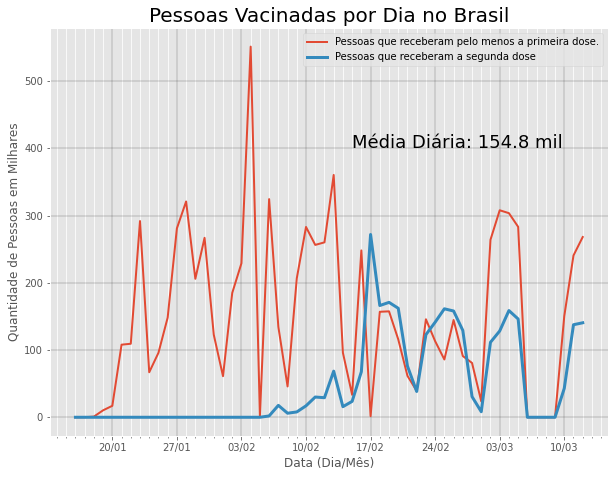

In [85]:
fig, ax = plt.subplots(figsize=(10,7.5))

ax.grid(b=True, c='k', alpha=0.1, linewidth=2)

ax.plot(df_diario['people_vaccinated'], linewidth=2, label='Pessoas que receberam pelo menos a primeira dose.')
ax.plot(df_diario['people_fully_vaccinated'], linewidth=3, label='Pessoas que receberam a segunda dose')

ax.set_title('Pessoas Vacinadas por Dia no Brasil', fontsize=20)

ax.set_xlabel('Data (Dia/Mês)')
ax.set_ylabel('Quantidade de Pessoas em Milhares')

ax.xaxis.grid(True, which='minor')
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))   #to get a tick every 15 minutes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m')) 

ax.text(pd.Timestamp('2021-02-15'),400,media_str, fontsize=18)

ax.legend(loc=0)

## Plotando a Média Movel de Vacinações Diarias

In [9]:
df_roll = (df_vac.fillna(method='ffill')['2021-01-15':].fillna(0).diff().rolling(7).mean() / 1000).round(2)

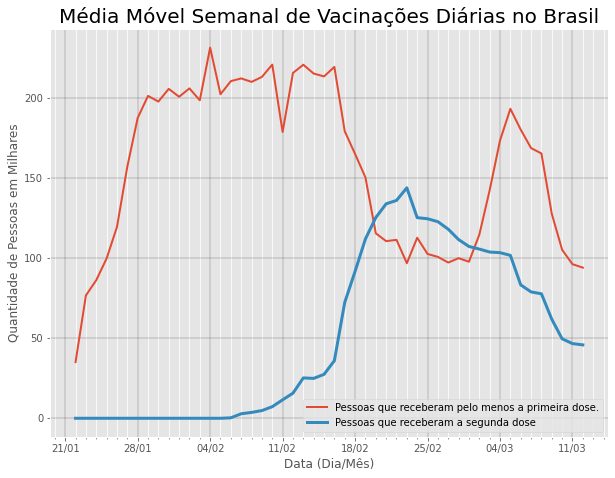

In [10]:
fig2, ax2 = plt.subplots(figsize=(10,7.5))

ax2.grid(b=True, c='k', alpha=0.1, linewidth=2)

ax2.plot(df_roll['people_vaccinated'], linewidth=2, label='Pessoas que receberam pelo menos a primeira dose.')
ax2.plot(df_roll['people_fully_vaccinated'], linewidth=3, label='Pessoas que receberam a segunda dose')

ax2.set_title('Média Móvel Semanal de Vacinações Diárias no Brasil', fontsize=20)

ax2.set_xlabel('Data (Dia/Mês)')
ax2.set_ylabel('Quantidade de Pessoas em Milhares')

ax2.xaxis.grid(True, which='minor')
ax2.xaxis.set_minor_locator(mdates.DayLocator(interval=1))

ax2.xaxis.set_major_locator(mdates.DayLocator(interval=7))   #to get a tick every 15 minutes
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m')) 

ax2.legend(loc=0)

## Modelo de Previsão ARMA

Começamos obtendo os valores absolutos de vacinações novamente, pois assim podemos fazer um previsão de quando toda a população brasileira será vacinada (~220 milhões).

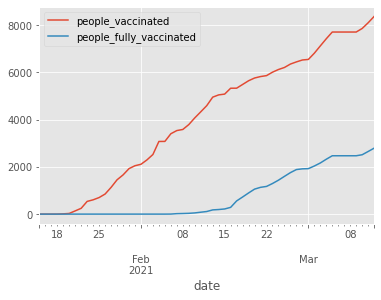

In [11]:
df_absolute = (df_vac.fillna(method='ffill')['2021-01-15':].fillna(0) / 1000).round(2)

df_absolute.plot()

### Plotando a auto-correlação podemos esperar a ordem 6 de relevancia para a parte AR.

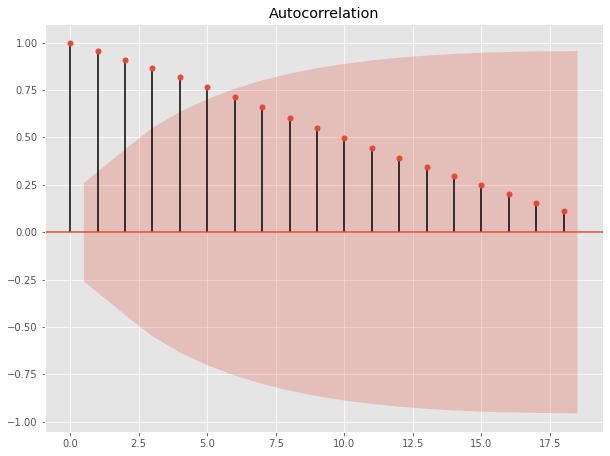

In [15]:
figacf, axacf = plt.subplots(figsize=(10,7.5))

plot_acf(df_absolute['people_vaccinated'],ax=axacf)

plt.show()

### Na auto-correlação parcial, podemos perceber uma ordem 2 para a relevância da parte MA do modelo.

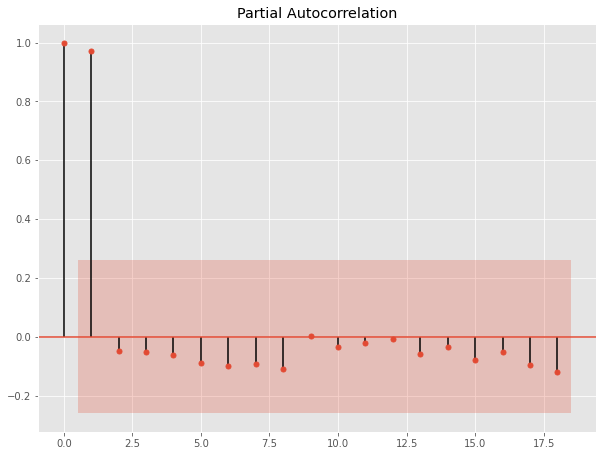

In [16]:
figpacf, axpacf = plt.subplots(figsize=(10,7.5))

plot_pacf(df_absolute['people_vaccinated'],ax=axpacf)

plt.show()

### Aplicando os dados ao modelo ARMA (6,2) e também forçando uma tendência linear que podemos perceber pelo primeiro gráfico de valores absolutos.

In [ ]:
modelo = ARIMA(df_absolute['people_vaccinated'], order=(6,0,2), trend='ct', enforce_stationarity=True).fit()

In [84]:
prediction = modelo.predict('2021-01-18','2024-12-31')

###  A partir do nosso modelo e previsões feitos por ele, podemos comparar este com nossos dados e vermos seu desempenho, que neste caso é bem satisfatório.

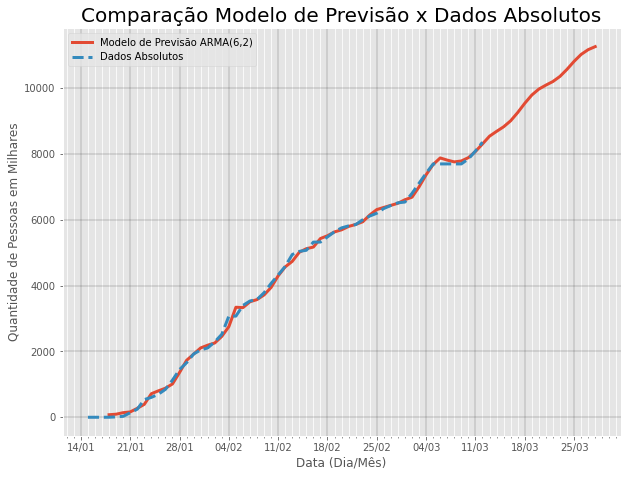

In [75]:
figpred, axpred = plt.subplots(figsize=(10,7.5))

axpred.grid(b=True, c='k', alpha=0.1, linewidth=2)

axpred.plot(prediction[:70], linewidth=3, ls ='-', label='Modelo de Previsão ARMA(6,2)', )
axpred.plot(df_absolute['people_vaccinated'], ls='--', linewidth=3, label='Dados Absolutos')

axpred.set_title('Comparação Modelo de Previsão x Dados Absolutos', fontsize=20)

axpred.set_xlabel('Data (Dia/Mês)')
axpred.set_ylabel('Quantidade de Pessoas em Milhares')

axpred.xaxis.grid(True, which='minor')
axpred.xaxis.set_minor_locator(mdates.DayLocator(interval=1))

axpred.xaxis.set_major_locator(mdates.DayLocator(interval=7))   #to get a tick every 15 minutes
axpred.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m')) 

axpred.legend(loc=0)


### E finalmente com isso podemos prever quando a quantidade de pessoas irá ultrapassar a marca das 220 milhões de pessoas, que neste caso temos 5 de outubro de 2024 caso o ritmo de vacinação se mantenha da forma atual.

In [83]:
prediction[(prediction > 220000) == True].index[0]

Timestamp('2024-10-05 00:00:00', freq='D')